In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'qj'
category = 'synthetic'
eccentricity = 'periphery'
movie_id = 5
diameter = 36; # 6, 24, 36
dat_movie_name = 'PRAIRIE'   # movie name as in the data file name
stim_movie_name = 'prairie1' # movie name as in the stimulus file name
n_bootstraps = 1

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
# n_dim = n_frames - 1
n_dim = 5
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 334.7726000547409
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 2 | Loss: 343.70708126202226
Current loss: 353.6437056809664
Loss updated
Iteration 3 | Loss: 353.6437056809664
Current loss: 328.7029599659145
Loss updated
Iteration 4 | Loss: 328.7029599659145
Current loss: 325.8875713609159
Loss updated
Iteration 5 | Loss: 325.8875713609159
Current loss: 332.26328978687525
Iteration 6 | Loss: 332.26328978687525
Current loss: 355.22477515786886
Iteration 7 | Loss: 355.22477515786886
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 8 | Loss: 328.31760580837727
Current loss: 333.0139519646764
Iteration 9 | Loss: 333.0139519646764
Current loss: 323.80840293318033
Loss updated
Iteration 10 | Loss: 323.80840293318033


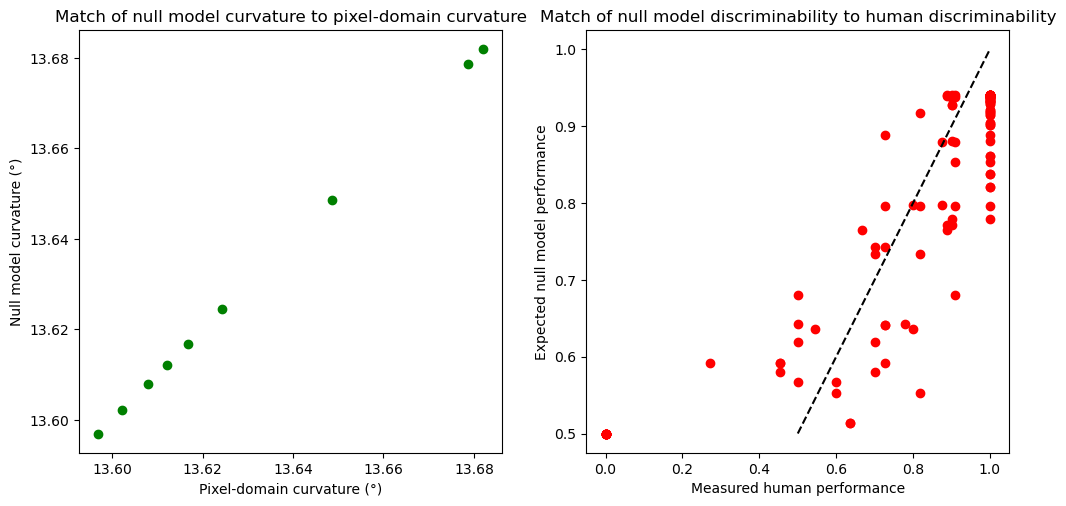

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Measured human performance')
axs[1].set_ylabel('Expected null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [6]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps, var = 0.5)

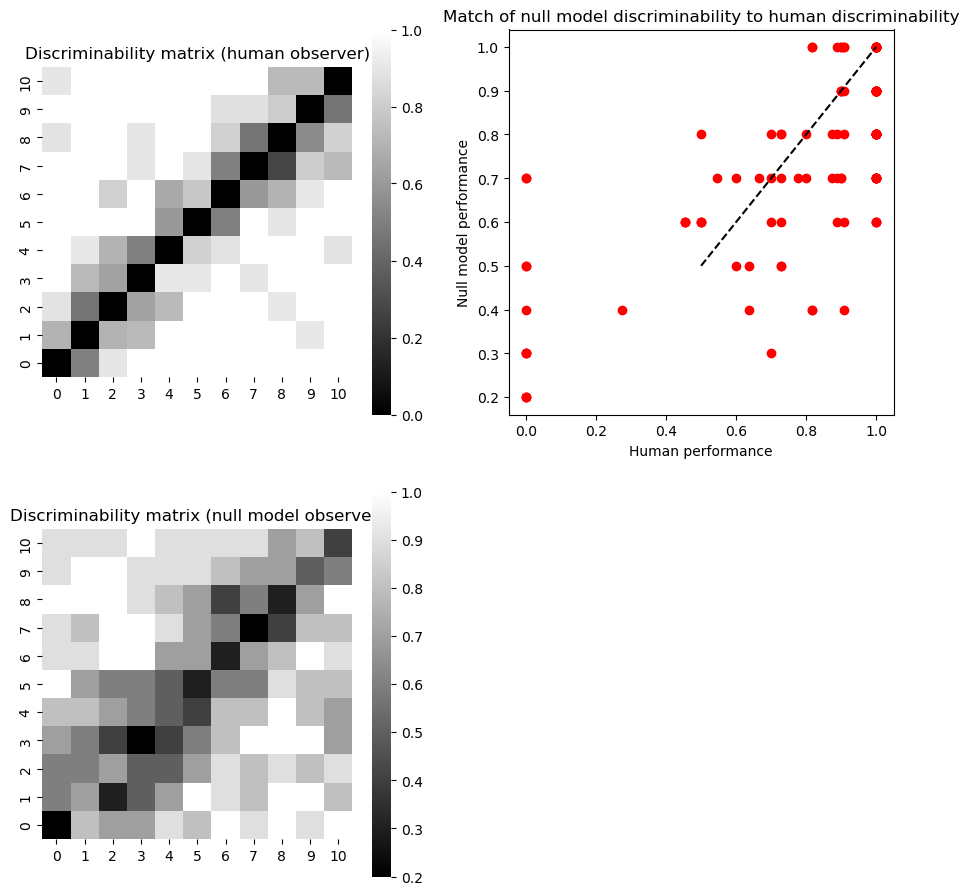

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [8]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, c_post_null, d_post_null, l_post_null, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 417.1578451022506
Current loss: 423.99436620622873
Loss updated
Iteration 2 | Loss: 423.99436620622873
Current loss: 405.65401523560286
Loss updated
Iteration 3 | Loss: 405.65401523560286
Current loss: 411.9498752206564
Iteration 4 | Loss: 411.9498752206564
Current loss: 408.83457536250353
Iteration 5 | Loss: 408.83457536250353
Current loss: 430.8952642902732
Iteration 6 | Loss: 430.8952642902732
Current loss: 414.75139366835356
Iteration 7 | Loss: 414.75139366835356
Current loss: 408.93425465375185
Iteration 8 | Loss: 408.93425465375185
Current loss: 413.0683711618185
Iteration 9 | Loss: 413.0683711618185
Current loss: 408.51437374949455
Iteration 10 | Loss: 408.51437374949455
Epoch: 0, Loss: 779.2707112845214
Epoch: 250, Loss: 702.1479750057438
Epoch: 500, Loss: 649.7878548102013
Epoch: 750, Loss: 619.7764508854285
Epoch: 1000, Loss: 592.4883818941539
Epoch: 1250, Loss: 57

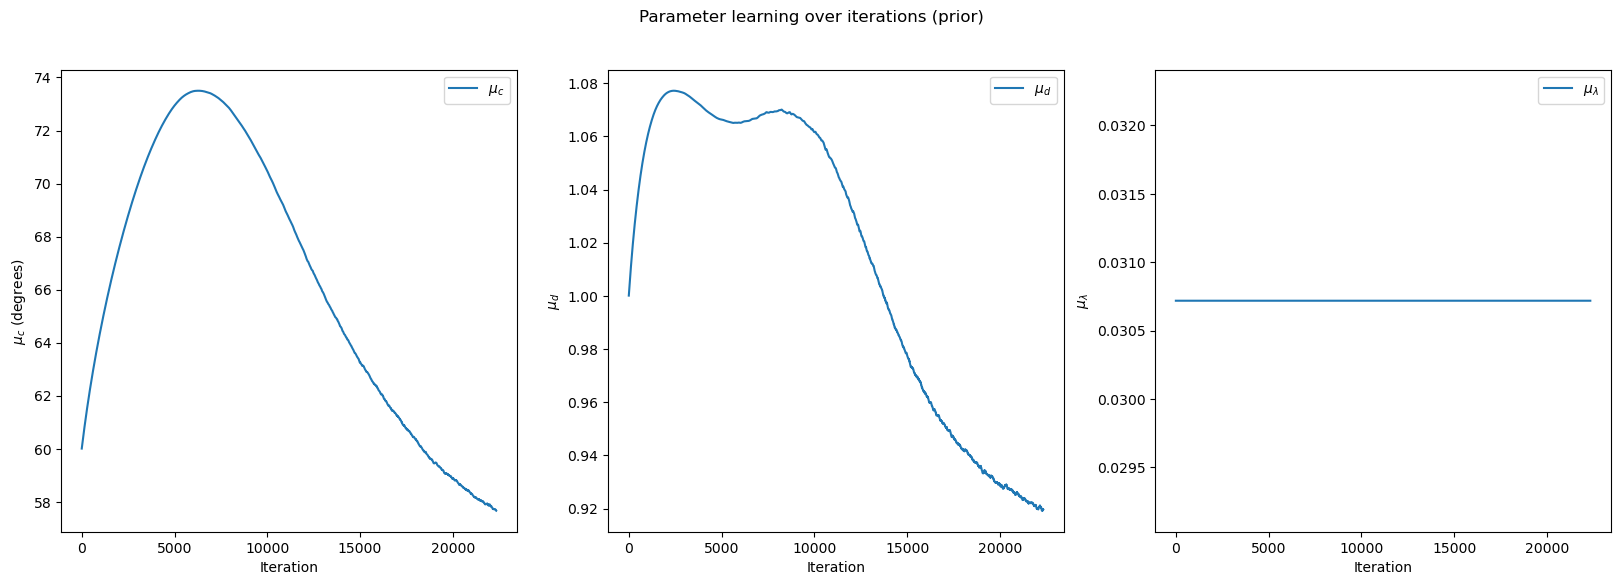

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior_null, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior_null, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior_null, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_62902/2674834642.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post_null.T)


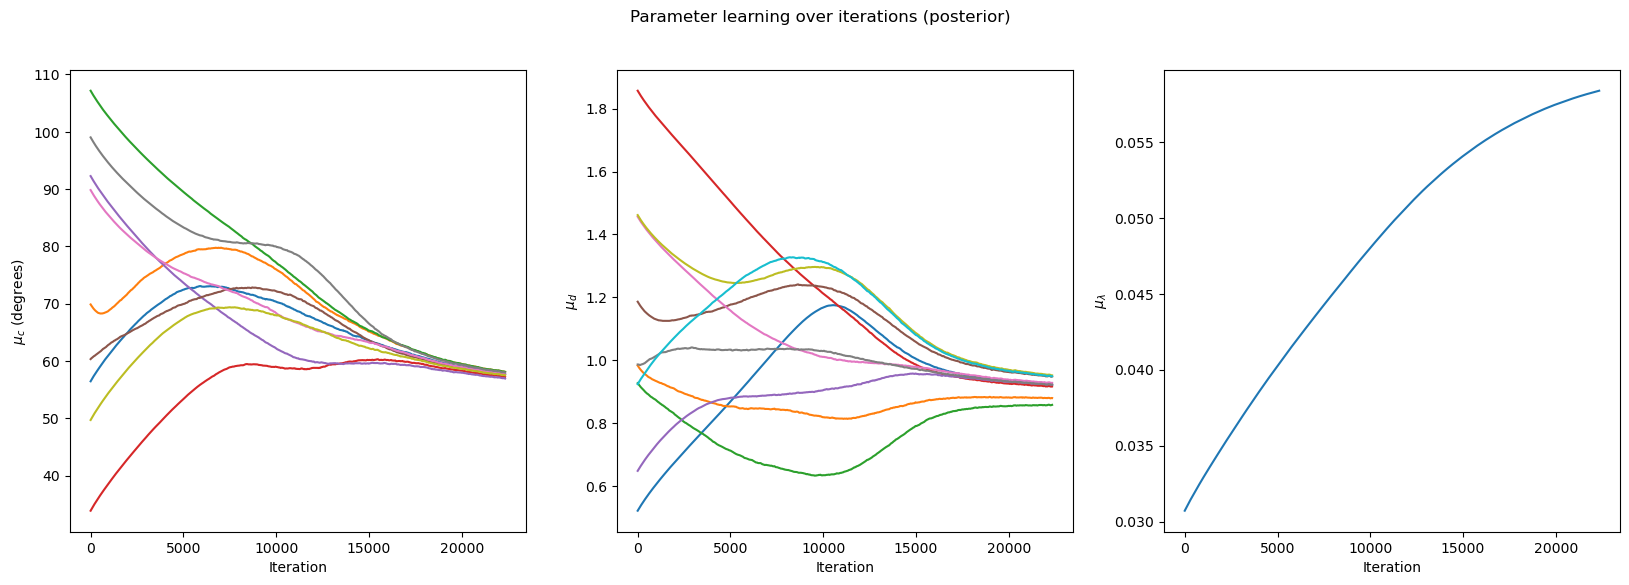

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post_null.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post_null.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post_null.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [11]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 57.662437438964844 degrees
Average estimated local curvature: 57.66088046172341 degrees


### Run optimization on real data

In [12]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 414.6431803777814
Loss updated
Iteration 1 | Loss: 414.6431803777814
Current loss: 333.54203351959586
Loss updated
Iteration 2 | Loss: 333.54203351959586
Current loss: 381.4531084895134
Iteration 3 | Loss: 381.4531084895134
Current loss: 350.5232577174902
Iteration 4 | Loss: 350.5232577174902
Current loss: 321.73534928262234
Loss updated
Iteration 5 | Loss: 321.73534928262234
Current loss: 358.6047125160694
Iteration 6 | Loss: 358.6047125160694
Current loss: 355.0013051889837
Iteration 7 | Loss: 355.0013051889837
Current loss: 371.39119377732277
Iteration 8 | Loss: 371.39119377732277
Current loss: 339.4352240562439
Iteration 9 | Loss: 339.4352240562439
Current loss: 335.14410999417305
Iteration 10 | Loss: 335.14410999417305
Epoch: 0, Loss: 762.6771984016103
Epoch: 250, Loss: 656.7682858721562
Epoch: 500, Loss: 586.1785388682197
Epoch: 750, Loss: 546.3539620023057
Epoch: 1000, Loss: 513.3261322134938
Epoch: 1250

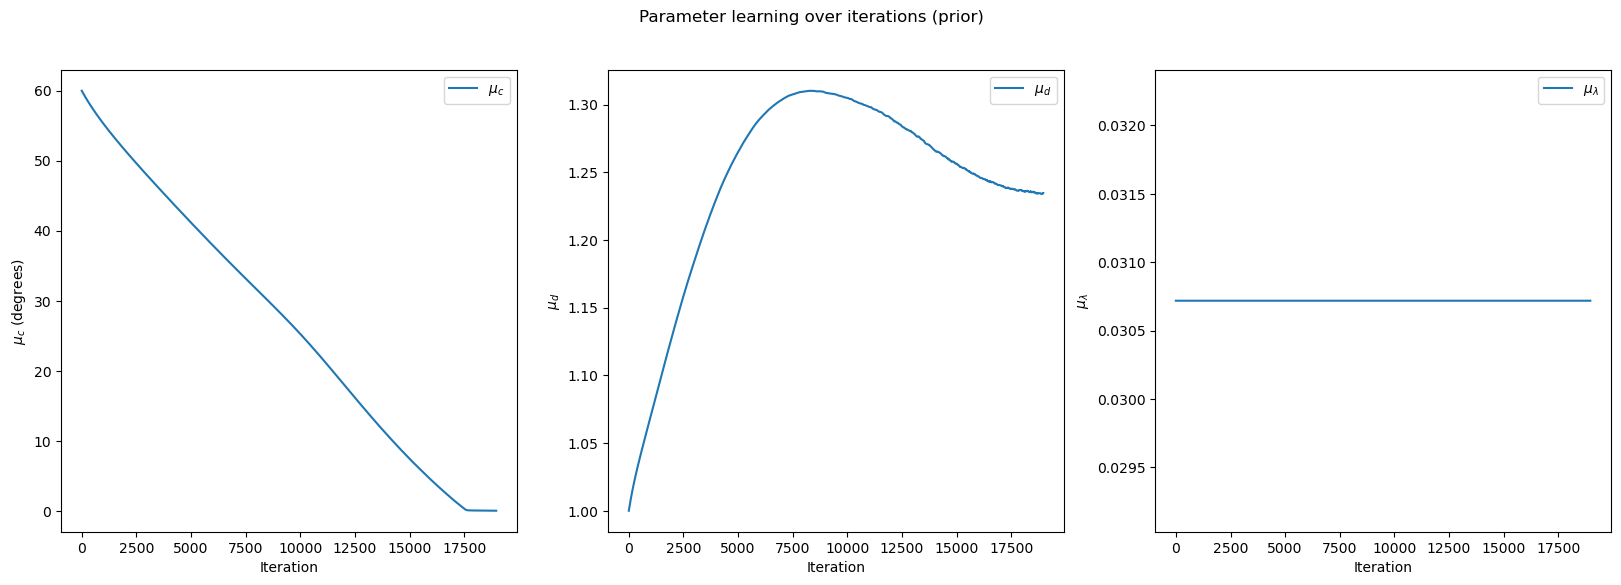

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

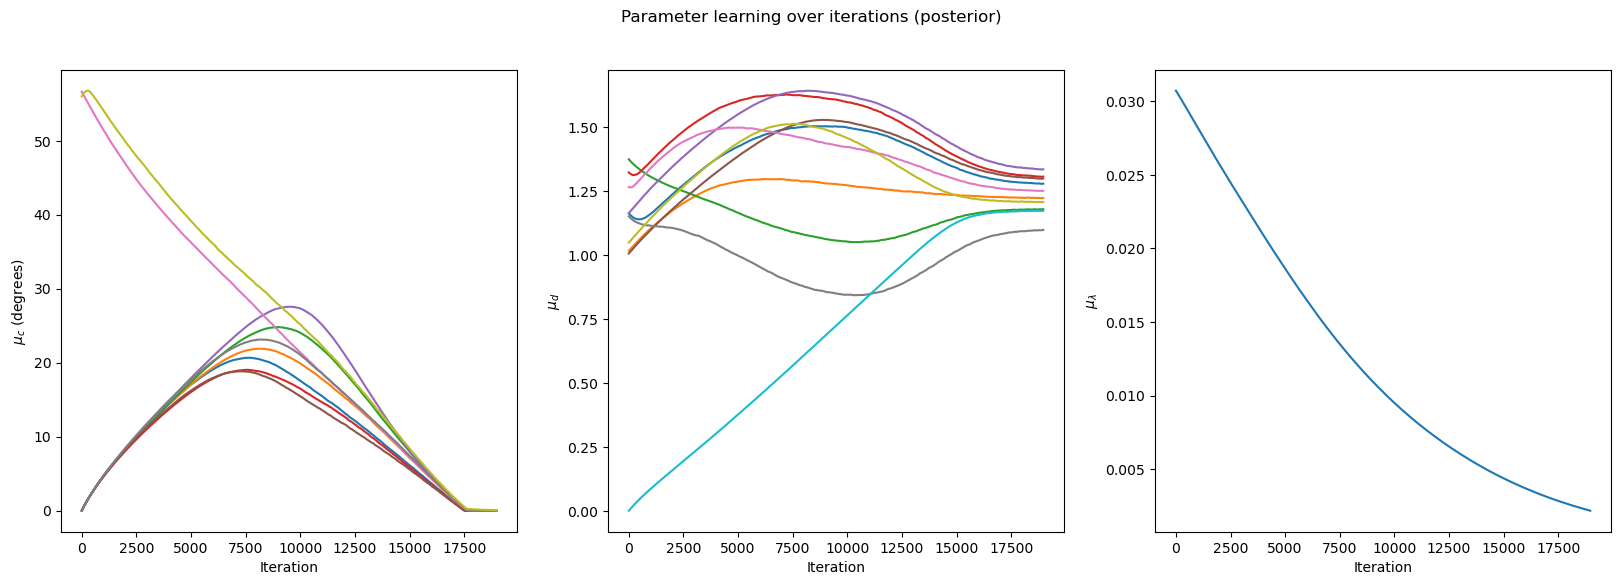

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [15]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 0.014903401024639606 degrees
Average estimated local curvature: -0.003972338319739143 degrees


### Analyze results

In [16]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

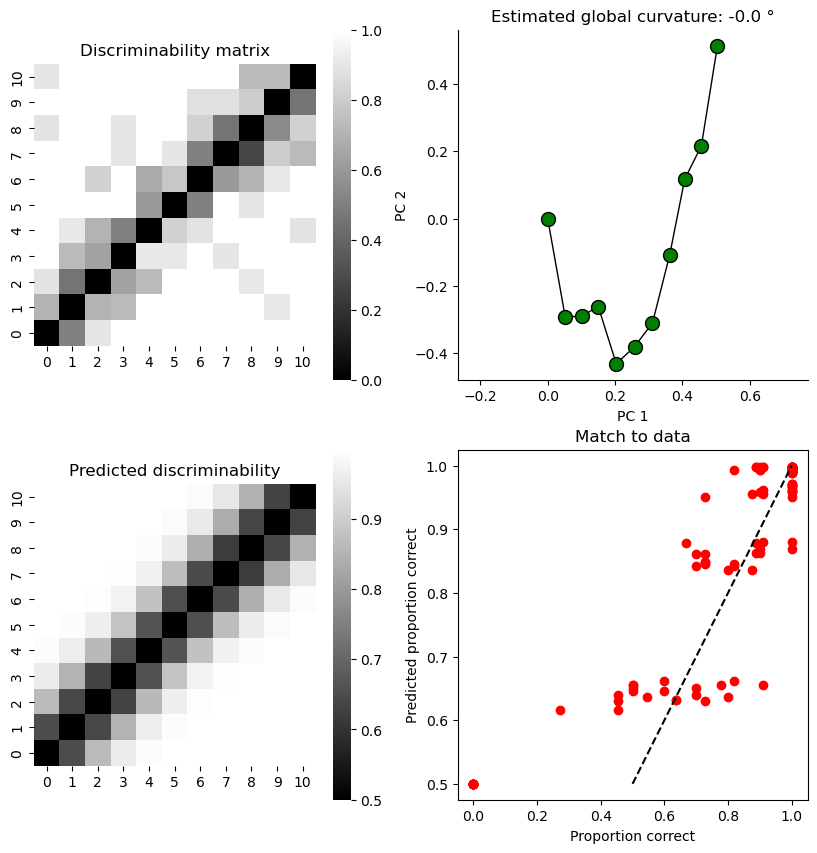

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()